In [1]:
pip install opencv-python mediapipe pyautogui keyboard pygame

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\abhin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import cv2
import mediapipe as mp
import pyautogui
import numpy as np
import time
from IPython.display import display, Image, clear_output
import ipywidgets as widgets


pyautogui.FAILSAFE = True  
pyautogui.PAUSE = 0.15  


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_draw = mp.solutions.drawing_utils


cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")

In [3]:

prev_index_x = None
prev_index_y = None
movement_threshold = 0.05  
 
def detect_gesture(landmarks):
    global prev_index_x, prev_index_y

    # Get key landmarks
    wrist = landmarks[0]
    index_tip = landmarks[8]
    thumb_tip = landmarks[4]
    middle_tip = landmarks[12]
    ring_tip = landmarks[16]
    pinky_tip = landmarks[20]

    
    index_to_middle = np.sqrt((index_tip.x - middle_tip.x)**2 + (index_tip.y - middle_tip.y)**2)
    fingers_spread = index_to_middle > 0.1
    open_palm = (
        fingers_spread and
        np.sqrt((middle_tip.x - ring_tip.x)**2 + (middle_tip.y - ring_tip.y)**2) > 0.1 and
        np.sqrt((ring_tip.x - pinky_tip.x)**2 + (ring_tip.y - pinky_tip.y)**2) > 0.1
    )

    if open_palm:
        return "Open Palm"

    
    if prev_index_x is None or prev_index_y is None:
        prev_index_x, prev_index_y = index_tip.x, index_tip.y
        return "Neutral"

    
    delta_x = index_tip.x - prev_index_x
    delta_y = index_tip.y - prev_index_y
    prev_index_x, prev_index_y = index_tip.x, index_tip.y

    
    if abs(delta_x) > movement_threshold or abs(delta_y) > movement_threshold:
        if abs(delta_x) > abs(delta_y):  
            if delta_x < -movement_threshold:
                return "Left Tilt"
            elif delta_x > movement_threshold:
                return "Right Tilt"
        else:  # Vertical movement
            if delta_y < -movement_threshold:  
                return "Open Hand"
            elif delta_y > movement_threshold: 
                return "Slide"

    return "Neutral"

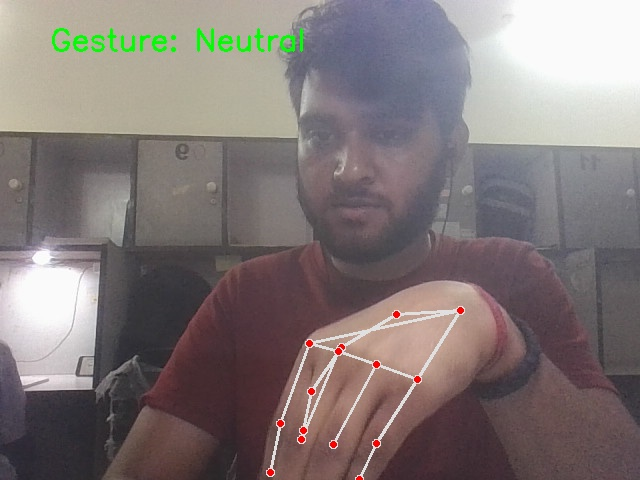

In [4]:

print("Click the Subway Surfers window (Poki) to focus it. You have 5 seconds.")
time.sleep(5)

last_gesture = "Neutral"
frame_count = 0
max_frames = 1000  

try:
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame.")
            break

       
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        
        results = hands.process(rgb_frame)

        gesture = "Neutral"
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
               
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
               
                gesture = detect_gesture(hand_landmarks.landmark)

                
                if gesture != last_gesture:
                    if gesture == "Open Hand":
                        pyautogui.press('up')
                    elif gesture == "Slide":
                        pyautogui.press('down')
                    elif gesture == "Left Tilt":
                        pyautogui.press('left')
                    elif gesture == "Right Tilt":
                        pyautogui.press('right')
                    elif gesture == "Open Palm":
                        pyautogui.press('space')

                last_gesture = gesture

        
        cv2.putText(frame, f"Gesture: {gesture}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

       
        ret, buffer = cv2.imencode('.jpg', frame)
        frame_bytes = buffer.tobytes()

        
        clear_output(wait=True)
        display(Image(data=frame_bytes))

        frame_count += 1

       
        time.sleep(0.03)

except KeyboardInterrupt:
    print("Stopped by user.")

finally:
    cap.release()
    cv2.destroyAllWindows()